# Purchase User Behavior Analytics for Expedia

Expedia.com, a large online travel agency (OTA), has collected a rich dataset on search behaviors. The dataset contains detailed information of all properties that were displayed in each search session (srch_id), whether the customer clicked on a property (click_bool) and whether he/she made a booking (booking_bool). 

Two business questions to be answered:
1. Build a model that predicts the likelihood a property will be clicked upon (indicating the customer is interested)
2. Build a model that predicts the likelihood a property that has been clicked upon will be booked


In [57]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist 
from sklearn.metrics import classification_report as report
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.svm import SVC
from sklearn.cluster import KMeans 
%matplotlib inline

In [2]:
expe = pd.read_csv('B8816-TakeHomeFinal-question4.csv')

In [3]:
expe

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,4/4/2013 8:32,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,4/4/2013 8:32,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,4/4/2013 8:32,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,4/4/2013 8:32,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,4/4/2013 8:32,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,13431,3/25/2013 10:55,5,219,NaN,NaN,219,101543,4,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
199996,13431,3/25/2013 10:55,5,219,NaN,NaN,219,101874,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
199997,13431,3/25/2013 10:55,5,219,NaN,NaN,219,103830,3,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
199998,13431,3/25/2013 10:55,5,219,NaN,NaN,219,112479,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [4]:
expe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   srch_id                      200000 non-null  int64  
 1   date_time                    200000 non-null  object 
 2   site_id                      200000 non-null  int64  
 3   visitor_location_country_id  200000 non-null  int64  
 4   visitor_hist_starrating      10831 non-null   float64
 5   visitor_hist_adr_usd         10859 non-null   float64
 6   prop_country_id              200000 non-null  int64  
 7   prop_id                      200000 non-null  int64  
 8   prop_starrating              200000 non-null  int64  
 9   prop_review_score            199719 non-null  float64
 10  prop_brand_bool              200000 non-null  int64  
 11  prop_location_score1         200000 non-null  float64
 12  prop_location_score2         156405 non-null  float64
 13 

## Data Preprocessing

### Missing Values Imputation

In [5]:
# drop columns that probably won't contribute much information to the clicking and booking prediction
drop_columns = ['srch_id','date_time','visitor_hist_starrating','visitor_hist_adr_usd','prop_id','prop_country_id','srch_query_affinity_score','orig_destination_distance']
expe = expe.drop(columns = drop_columns)

In [6]:
expe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   site_id                      200000 non-null  int64  
 1   visitor_location_country_id  200000 non-null  int64  
 2   prop_starrating              200000 non-null  int64  
 3   prop_review_score            199719 non-null  float64
 4   prop_brand_bool              200000 non-null  int64  
 5   prop_location_score1         200000 non-null  float64
 6   prop_location_score2         156405 non-null  float64
 7   prop_log_historical_price    200000 non-null  float64
 8   position                     200000 non-null  int64  
 9   price_usd                    200000 non-null  float64
 10  promotion_flag               200000 non-null  int64  
 11  srch_destination_id          200000 non-null  int64  
 12  srch_length_of_stay          200000 non-null  int64  
 13 

Since there are many null data in competitors' data, we have to integrate some infomation.

First, calculate number of competitors with lower price and avalibility, which is the 'real' competitors for Expedia.

In [7]:
columns1 = ['comp1_rate','comp2_rate','comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate']
columns2 = ['comp1_inv','comp2_inv','comp3_inv','comp4_inv','comp5_inv','comp6_inv','comp7_inv','comp8_inv']
expe['Num_comp'] = ((expe[columns1] == 1) &(expe[columns2] == -1)).sum(axis = 1)

In [8]:
expe['Num_comp'].value_counts()

0    200000
Name: Num_comp, dtype: int64

It turns out that __no competitor have both avalibility and lower price__, which means we don't have to worry about competitors.

In [9]:
columns3 = ['comp1_rate_percent_diff','comp2_rate_percent_diff','comp3_rate_percent_diff','comp4_rate_percent_diff','comp5_rate_percent_diff','comp6_rate_percent_diff','comp7_rate_percent_diff','comp8_rate_percent_diff']
expe = expe.drop(columns = columns1)
expe = expe.drop(columns = columns2)
expe = expe.drop(columns = columns3)
expe = expe.drop(columns = ['Num_comp'])

The 'gross_bookings_usd' indicates similar information of 'price_usd' and 'booking_bool', but has a lot of missing values. Drop this column.

In [10]:
expe = expe.drop(columns = ['gross_bookings_usd'])

In [11]:
expe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   site_id                      200000 non-null  int64  
 1   visitor_location_country_id  200000 non-null  int64  
 2   prop_starrating              200000 non-null  int64  
 3   prop_review_score            199719 non-null  float64
 4   prop_brand_bool              200000 non-null  int64  
 5   prop_location_score1         200000 non-null  float64
 6   prop_location_score2         156405 non-null  float64
 7   prop_log_historical_price    200000 non-null  float64
 8   position                     200000 non-null  int64  
 9   price_usd                    200000 non-null  float64
 10  promotion_flag               200000 non-null  int64  
 11  srch_destination_id          200000 non-null  int64  
 12  srch_length_of_stay          200000 non-null  int64  
 13 

Fill the rest of the missing values with 0.

In [12]:
expe.replace(np.nan,0,inplace=True)

### Exploratory Data Analysis

In [13]:
expe.promotion_flag.value_counts()

0    157082
1     42918
Name: promotion_flag, dtype: int64

In [14]:
np.mean(expe.prop_review_score)

3.7934725

In [15]:
np.mean(expe.prop_starrating)

3.197935

In [16]:
expe.click_bool.value_counts()

0    191046
1      8954
Name: click_bool, dtype: int64

Only 4% of the properties are clicked.

This ratio is very low, which means that if we fit a model with this unbalanced dataset, it is very likely that the click_bool prediction from the model will all be 0. Also as clicking and booking is more valuable than not for Expedia, the cost function should be altered so that the false negative will be penalized more. So we have to do resampling. 

In [17]:
expe[expe.click_bool == 1].booking_bool.value_counts()

1    5599
0    3355
Name: booking_bool, dtype: int64

#### Some insights:

- 20% of the properties have promotion displayed.
- The mean of property review score is 3.8.
- The mean of property star rating is 3.2.
- __Only 4% of the properties are clicked.__
This ratio is very low, which means that if we fit a model with this unbalanced dataset, it is very likely that the click_bool prediction from the model will all be 0. Also as clicking and booking is more valuable than not for Expedia, the cost function should be altered so that the false negative will be penalized more. So we have to do resampling.
- Among all the properties that are clicked, about 63% of the properties are booked, which is quite a high ratio. There's no resampling needed when predicting booking_bool.


### Use Clustering to Refine the Dataset

When trying to predict the click_bool, intuitively the clicking behavior from a certain user can be very random, and the clicking behavior itself is very sparse. __We use clustering methods to first define clustering of users and hotels__, in order to find a clearer clue of a more general trend of what kind of users are more likely to click a certain kind of hotels.

__K-means__ is used here to do the clustering. 

In [18]:
feature_vis = ['site_id','visitor_location_country_id','srch_length_of_stay','srch_booking_window',\
               'srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool']
feature_hot = ['prop_starrating','prop_review_score','prop_brand_bool','prop_location_score1','prop_location_score2',\
              'prop_log_historical_price','srch_destination_id']

In [19]:
x = expe.iloc[:,:19]
y_c = expe.iloc[:,19]
y_b = expe.iloc[:,20]

Due to the attribution of this method, the features have to be normalized first.

In [20]:
visitor = StandardScaler().fit_transform(x[feature_vis])
hotel = StandardScaler().fit_transform(x[feature_hot])

In [21]:
visitor = pd.DataFrame(visitor,columns = feature_vis)
visitor

,site_id,visitor_location_country_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool
0,0.272105,0.169954,-0.671561,-0.722370,2.452404,-0.486528,-0.269187,1.003035
1,0.272105,0.169954,-0.671561,-0.722370,2.452404,-0.486528,-0.269187,1.003035
2,0.272105,0.169954,-0.671561,-0.722370,2.452404,-0.486528,-0.269187,1.003035
3,0.272105,0.169954,-0.671561,-0.722370,2.452404,-0.486528,-0.269187,1.003035
4,0.272105,0.169954,-0.671561,-0.722370,2.452404,-0.486528,-0.269187,1.003035
...,...,...,...,...,...,...,...,...
199995,-0.639329,0.652237,-0.183306,-0.516153,-1.153321,0.896971,-0.269187,1.003035
199996,-0.639329,0.652237,-0.183306,-0.516153,-1.153321,0.896971,-0.269187,1.003035
199997,-0.639329,0.652237,-0.183306,-0.516153,-1.153321,0.896971,-0.269187,1.003035
199998,-0.639329,0.652237,-0.183306,-0.516153,-1.153321,0.896971,-0.269187,1.003035


Use distortions as the measurement to support the elbow method and determine the parameter k.

In [22]:
distortions = [] 

K = range(1,80,10) 
  
for k in K: 
    #Building and fitting the model 
    vis_cluster = KMeans(n_clusters=k).fit(visitor)     
    distortions.append(sum(np.min(cdist(visitor, vis_cluster.cluster_centers_, 
                      'euclidean'),axis=1)) / visitor.shape[0]) 
    print(k)

1
11
21
31
41
51
61
71


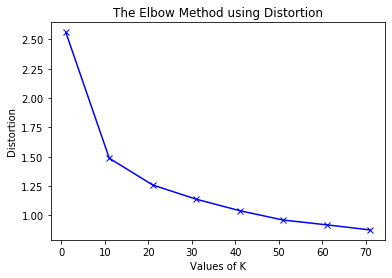

In [23]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [24]:
vis_cluster = KMeans(n_clusters=40,random_state = 0).fit(visitor)
x['visitor_cluster'] = vis_cluster.labels_

In [25]:
hotel = pd.DataFrame(hotel,columns = feature_hot)
hotel.replace(np.nan,0,inplace=True)

In [26]:
distortions2 = [] 
  
for k in K: 
    #Building and fitting the model 
    hot_cluster = KMeans(n_clusters=k).fit(hotel)     
    distortions2.append(sum(np.min(cdist(hotel, hot_cluster.cluster_centers_, 
                      'euclidean'),axis=1)) / hotel.shape[0]) 
    print(k)

1
11
21
31
41
51
61
71


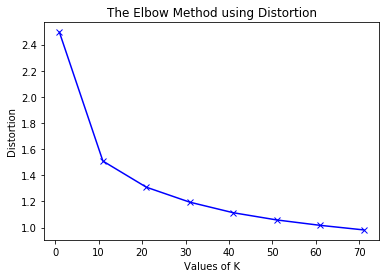

In [27]:
plt.plot(K, distortions2, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [28]:
hot_cluster = KMeans(n_clusters=40,random_state = 0).fit(hotel)
x['hotel_cluster'] = hot_cluster.labels_

In [29]:
x.drop(columns = feature_vis,inplace = True)
x.drop(columns = feature_hot,inplace = True)
x['visitor_cluster'] = x['visitor_cluster'].astype(str)
x['hotel_cluster'] = x['hotel_cluster'].astype(str)

Now that users' and hotels' information is integrated in the `visitor_cluster` and `hotel_cluster` columns, remove the original columns that we derived the clusters from.

In [30]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   position         200000 non-null  int64  
 1   price_usd        200000 non-null  float64
 2   promotion_flag   200000 non-null  int64  
 3   random_bool      200000 non-null  int64  
 4   visitor_cluster  200000 non-null  object 
 5   hotel_cluster    200000 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


### Resample the Imbalanced Dataset

Under-sample click_bool = 0 by 1/10 and over-sample click_bool = 1 by 2 times.

In [31]:
x1 = x[y_c == 1]
x0 = x[y_c == 0]
n1 = len(x1)
n0 = len(x0)
x1 = x1.sample(2*n1,replace=True,random_state=0)
x0 = x0.sample(int(n0/10), replace=True,random_state=0)
x_c = pd.concat([x0, x1], axis=0)

In [32]:
y_c = y_c.iloc[x_c.index]

### Train/Validation Split

In [33]:
train_xc,valid_xc,train_yc,valid_yc = train_test_split(x_c,y_c,test_size = 0.3,random_state = 1)

## Classification Models Training

Because the “clicking” is more important than “not clicking”, which means false negative should be penalized more than false negative, we should use a metrics other than misclassification error to select a good model. I chose __recall__, true positive / (true positive + false negative) as the most important metrics, and __0-recall__, true negative / (true negative + false positive) as the second important metrics. These 2 metrics have a trade-off.

### Part 1: Predict `click_bool`

### Random Forest

In [34]:
model_rf_c = rfc().fit(train_xc,train_yc)

In [35]:
pred_yc1 = model_rf_c.predict(valid_xc)
print(report(valid_yc,pred_yc1))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      5798
           1       0.80      0.88      0.84      5306

    accuracy                           0.84     11104
   macro avg       0.84      0.84      0.84     11104
weighted avg       0.84      0.84      0.84     11104



### Gredient Boost

In [36]:
model_gbc_c = gbc(learning_rate=0.01).fit(train_xc,train_yc)

In [37]:
pred_yc2 = model_gbc_c.predict(valid_xc)
print(report(valid_yc,pred_yc2))

              precision    recall  f1-score   support

           0       0.67      0.78      0.72      5798
           1       0.71      0.58      0.64      5306

    accuracy                           0.69     11104
   macro avg       0.69      0.68      0.68     11104
weighted avg       0.69      0.69      0.68     11104



### Support Vector Machine

In [38]:
model_svm_c = SVC().fit(train_xc,train_yc)

In [39]:
pred_yc3 = model_svm_c.predict(valid_xc)
print(report(valid_yc,pred_yc3))

              precision    recall  f1-score   support

           0       0.75      0.53      0.62      5798
           1       0.61      0.81      0.70      5306

    accuracy                           0.66     11104
   macro avg       0.68      0.67      0.66     11104
weighted avg       0.68      0.66      0.66     11104



### Final model to predict click_bool: model_rf_c

<BarContainer object of 6 artists>

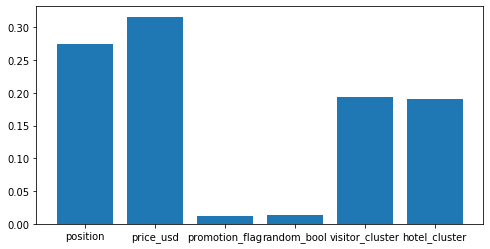

In [40]:
plt.figure(figsize=(8,4))
plt.bar(x.columns,model_rf_c.feature_importances_)

### Part 2: Predict `booking_bool`

In [41]:
y_c = expe.iloc[:,19]
y_b = expe.iloc[:,20]

#x_b1 = x[y_c == 1].drop(columns=['random_bool'])
x_b = x[y_c == 1]
y_b = y_b[y_c == 1]

In [42]:
# Split the dataset into training and validation sets
train_xb,valid_xb,train_yb,valid_yb = train_test_split(x_b,y_b,test_size = 0.3,random_state = 2)

### Random Forest

In [43]:
model_rf_b = rfc().fit(train_xb,train_yb)

In [44]:
pred_yb1 = model_rf_b.predict(valid_xb)
print(report(valid_yb,pred_yb1))

              precision    recall  f1-score   support

           0       0.88      0.76      0.81       997
           1       0.87      0.94      0.90      1690

    accuracy                           0.87      2687
   macro avg       0.87      0.85      0.86      2687
weighted avg       0.87      0.87      0.87      2687



### Gredient Boost

In [45]:
model_gbc_b = gbc(learning_rate=0.01).fit(train_xb,train_yb)

In [46]:
pred_yb2 = model_gbc_b.predict(valid_xb)
print(report(valid_yb,pred_yb2))

              precision    recall  f1-score   support

           0       0.89      0.75      0.82       997
           1       0.87      0.95      0.90      1690

    accuracy                           0.87      2687
   macro avg       0.88      0.85      0.86      2687
weighted avg       0.88      0.87      0.87      2687



### Support Vector Machine

In [47]:
model_svm_b = SVC(kernel='sigmoid').fit(train_xb,train_yb)

In [48]:
pred_yb3 = model_svm_b.predict(valid_xb)
print(report(valid_yb,pred_yb3))

              precision    recall  f1-score   support

           0       0.72      0.03      0.05       997
           1       0.63      0.99      0.77      1690

    accuracy                           0.64      2687
   macro avg       0.68      0.51      0.41      2687
weighted avg       0.67      0.64      0.51      2687



### Final model to predict book_bool: model_gbc_b

<BarContainer object of 6 artists>

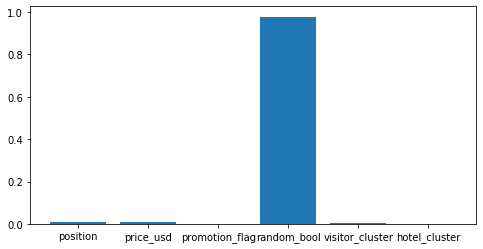

In [49]:
plt.figure(figsize=(8,4))
plt.bar(x_b.columns,model_gbc_b.feature_importances_)

<BarContainer object of 6 artists>

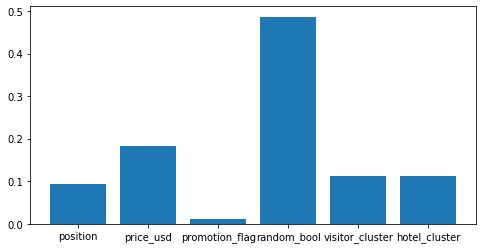

In [50]:
plt.figure(figsize=(8,4))
plt.bar(x_b.columns,model_rf_b.feature_importances_)

### Predict `booking_bool` only with `random_bool`

In [64]:
random = np.where(valid_xb.random_bool == 1,0,1)
print(report(valid_yb,random))

              precision    recall  f1-score   support

           0       0.89      0.75      0.82       997
           1       0.87      0.95      0.90      1690

    accuracy                           0.87      2687
   macro avg       0.88      0.85      0.86      2687
weighted avg       0.88      0.87      0.87      2687



## Conclusion

When predicting the clicking behavior, the random forest outperforms the others, with a recall of 0.88, a 0-recall of 0.80, and an accuracy of 0.84. 

From the feature importances, the top 2 features that determine if the user clicks a property are `price_usd` and `position`. `visitor_cluster` and `hotel_cluster` also play important role, while `promotion flag` and `random_bool` don't exert much influence. __This indicates that hotels with lower price and hotels that appear on top of the list, no matter the list is random or not, are generally more likely to be clicked, depend on users' and hotels' characters. However, promotion is not the top concern for customers.__

When predicting the booking behavior, the gredient boost outperforms the others, with a recall of 0.95, a 0-recall of 0.75, and an accuracy of 0.87. 

From the feature importances of random forest and gredient boost, a very interesting phenomenon is that __the `random_bool` really matters a lot__ to predict a booking behavior, while all the other features don't matter that much. Given the property is clicked, if we only use `random_bool` to predict `booking_bool`, random_bool = 1 -> booking_bool = 0 and vice versa, the recall and accuracy remain almost the same. This can be interpreted as: __The price of a hotel, position of a hotel on the list, users' features, hotels' other features mainly determine whether the user will click this property. But given that all those features are attractive enough for a user to click, if the list is randomized, then probably after the user opens the link, the user will find the property less satisfactory; if the list is not randomized, which means it is ranked based on the existing recommendation system, the clicked property will probably meets the user's need. This proves that a recommendation system is very useful for Expedia to promote sales.__

## Future Steps for a Recommendation System

### A scoring model that allows Expedia to rank order the list of properties for each customer based on the expected gross booking revenue:

1. __Determine a customer cluster.__ When having a certain customer, first use his/her history to determine which customer segment he/she belongs to. If this is a new customer, use his/her some basic information (e.g. geographical) to narrow down the clusters s/he could belong to, and then choose the most populated cluster.
2. __Estimate the probability whether a customer will click -> book a certain property.__ The expected revenue of this certain property from this customer can be estimated as price * probability. The scoring model takes this estimated revenue as the key factor to rank different properties for this customer.

In [54]:
x.to_csv('x.csv')